# AnimeGM - Style Transfer - Keras
GOAL: Generate new anime-style images

View model: `$ tensorboard --logdir=autoencoder`

Methodology:
1. Load the images and preprocess them to a consistent size, and shape
2. Build models for a, p, x using a pretrained model (VGG16)
3. Construct a placeholder array for style weights if the style layers
4. Extract feature representations to construct p and a, for each selected layer
5. Optimize with the BFGS algorithm

Important Functions:
1. Define a function to calculate the content loss
2. Define a function to calculate the style loss
3. Define a function to calculate the total loss
4. Define a function to calculate the gradient

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.misc import imresize, imsave
from scipy.optimize import fmin_l_bfgs_b
import seaborn as sns; sns.set()
import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.applications import vgg19
%matplotlib inline

/home/peter/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Functions

In [2]:
def show_image(image, resize_dim):
    """Shows an image.
    image: image data to show.
    resize_dim: the number of pixels the image should be per size.
    """
    image = image.reshape((resize_dim, resize_dim, 3))

    plt.imshow(image, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [3]:
def preprocess(img_path, resize_dim):
    # load the image from file system
    img = tf.keras.preprocessing.image.load_img(img_path)

    # convert it to an array
    img = tf.keras.preprocessing.image.img_to_array(img)

    # resize it
    img = imresize(img, (resize_dim, resize_dim, 3))

    # cast the image to a float64 
    img = img.astype('float32')
#     img = img.astype('float64')

    # add a batch number
    img = np.expand_dims(img, axis=0)

    # add the mean pixel values
    img = vgg19.preprocess_input(img)
    
    # show the image (it will be clipped)
    show_image(img, resize_dim)

    return img

In [4]:
def deprocess_image(channels, img, resize_dim):
    img = img.reshape((resize_dim, resize_dim, channels))
    
    # Remove zero-center by mean pixel
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    return img

In [5]:
def save_generated(channels, image, name, resize_dim):
    deprocessed_img = deprocess_image(channels, image, resize_dim)
    show_image(deprocessed_img, resize_dim)
    imsave('output/gen_{}.jpg'.format(name), deprocessed_img)

In [6]:
def content_loss(content, gen):
    """get the Euclidean distance between outputs of more for the content 
    and generated image at a specific layer"""
    # why sum of squared errors?
    # why not the mean squared errors?
    return K.sum(K.square(gen - content))

In [7]:
def get_content_loss(content_weight, outputs_dict):
    local_loss = 0
    
    # higher layers in the model are better for overall shapes
    layer_features = outputs_dict['block4_conv2']

    # index 0 because of our input tensor batching
    content_img_features = layer_features[0, :, :, :] 

    # index 2 because of our input tensor batching
    gen_img_features = layer_features[2, :, :, :]

    # use content_weight to give weight to the amount to use in the mix
    local_loss = content_weight * content_loss(content_img_features, gen_img_features)
    
    return local_loss

In [8]:
def gram_matrix(x):
    """calculates the gram matrix.
    dot product of the flattened feature map and transposed 
    flatten feature map"""
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram    

In [9]:
def style_loss(channels, gen, resize_dim, style):
    """calculates the Euclidean distance between gram matrices of 
    the feature maps of the inputs"""
    S = gram_matrix(style)
    G = gram_matrix(gen)
    size = resize_dim * resize_dim
    
    # divide by $ * size^2 * channels^2
    return K.sum(K.square(S - G) / (4. * (channels ** 2) * (size ** 2)))

In [10]:
def get_style_loss(channels, outputs_dict, resize_dim, style_weight):
    local_loss = 0
    
    # grab layer names for our style loss
    # notice that it's the first conv layer of each block
    feature_layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

    # get loss for each feature layer
    for name in feature_layer_names:
        # grab the layer
        layer_features = outputs_dict[name]

        # index 1 because of our input tensor batching
        style_features = layer_features[1, :, :, :]

        # index 2 because of our input tensor batching
        gen_img_features = layer_features[2, :, :, :]

        # get the style loss
        layer_style_loss = style_loss(channels, gen_img_features, resize_dim, style_features)

        # use style_weight to give weight to the amount to use in the mix
        # scale it based it on the number of faeture layers
        local_loss += (style_weight / len(feature_layer_names)) * layer_style_loss
    
    return local_loss

In [11]:
def total_variation_loss(image, resize_dim):
    assert K.ndim(image) == 4
    a = K.square(image[:, :resize_dim - 1, :resize_dim - 1, :] - image[:, 1:, :resize_dim - 1, :])
    b = K.square(image[:, :resize_dim - 1, :resize_dim - 1, :] - image[:, :resize_dim - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [12]:
def get_total_variation_loss(image, resize_dim, total_variation_loss_weight):
    local_loss = 0
    
    # check the pixel by pixel loss
    # reduce amount of noise in generated image 
    local_loss += total_variation_loss_weight * total_variation_loss(image, resize_dim)
    
    return local_loss

In [13]:
def eval_loss_and_grads(channels, f_output, image, resize_dim):
    reshaped_image = image.reshape((1, resize_dim, resize_dim, channels))
    outs = f_output([reshaped_image])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else: 
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [14]:
class Evaluator(object):
    def __init__(self, f_output):
        self.f_output = f_output
        self.grads_value = None
        self.loss_value = None
        
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_value = eval_loss_and_grads(channels, self.f_output, x, resize_dim)
        self.loss_value = loss_value
        self.grads_value = grad_value
        return self.loss_value
    
    def grads(self, x):
        assert self.loss_value is not None
        grads_values = np.copy(self.grads_value)
        self.loss_value = None
        self.grads_value = None
        return grads_values

### Variables

In [15]:
# data dir
content_path = 'images/content.png'
style_path = 'images/style.jpg'
gen_path = 'output/gen_'

# data manipulation
resize_dim = 100
channels = 3

In [16]:
# hyper parameters
content_weight = 0.025
style_weight = 1.0
total_variation_loss_weight = 1.0
iterations = 10
loss_iterations = 100

In [17]:
# loss
loss = 0

## Configure GPUs

In [18]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## 1. Load images

/home/peter/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


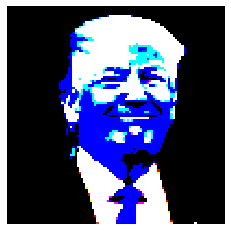

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


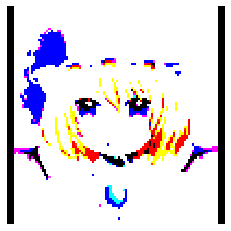

In [19]:
content_img = preprocess(content_path, resize_dim)
style_img = preprocess(style_path, resize_dim)

## Build the model

In [20]:
# load images into vars
content_img_var = K.variable(content_img)
style_img_var = K.variable(style_img)
gen_img = K.placeholder(shape=(1, resize_dim, resize_dim, 3))

# batch them all together
input_tensor = K.concatenate([content_img_var, style_img_var, gen_img], axis=0)

# load the trained VGG19 model with imagenet weights, and specify an input tensor
model = vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=input_tensor)

# make a dictionary of all the names and outputs of the model layers
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

## Losses

### Content Loss

In [21]:
# get the content loss and add it to the global loss
loss += get_content_loss(content_weight, outputs_dict)

### Style loss

In [22]:
# get the style loss and add it to the global loss    
loss += get_style_loss(channels, outputs_dict, resize_dim, style_weight)

### Total variation loss

In [23]:
# get the total variation loss
loss += get_total_variation_loss(gen_img, resize_dim, total_variation_loss_weight)

## Evaluating the gradients and loss

In [24]:
# get gradients
grads = K.gradients(loss, gen_img)

outputs = [loss]

# why ?
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_output = K.function([gen_img], outputs)

## Optimization

loss: 5412442112.0
info: {'grad': array([ -6054.09716797, -15186.19238281, -10074.28027344, ...,
          126.12001038,   2314.49487305,    115.32804871]), 'task': b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT', 'funcalls': 105, 'nit': 100, 'warnflag': 1}


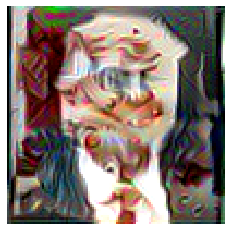

/home/peter/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.


loss: 5452211712.0
info: {'grad': array([-2456.02270508, -1994.08117676, -1573.94567871, ...,
        -638.98193359,   874.35595703,   -24.87857056]), 'task': b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT', 'funcalls': 105, 'nit': 100, 'warnflag': 1}


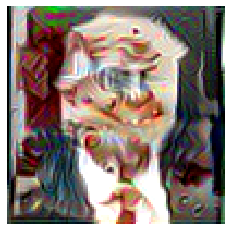

loss: 5435490304.0
info: {'grad': array([-2342.33618164, -9529.75585938, -8417.19140625, ...,
          63.44836426,  2329.35302734,   566.56799316]), 'task': b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT', 'funcalls': 104, 'nit': 100, 'warnflag': 1}


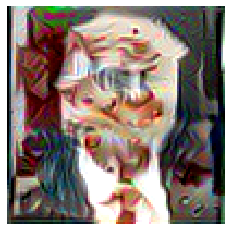

loss: 5385849856.0
info: {'grad': array([-5805.11523438, -9565.39257812, -9201.80078125, ...,
        -135.21658325,  2391.22167969,   218.89649963]), 'task': b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT', 'funcalls': 104, 'nit': 100, 'warnflag': 1}


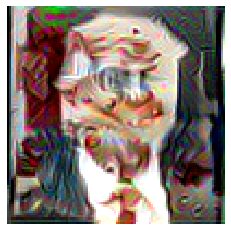

loss: 5477949440.0
info: {'grad': array([1901.87426758, 4112.51123047, 2953.64501953, ...,  -84.04105377,
        583.83557129, -491.31512451]), 'task': b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT', 'funcalls': 105, 'nit': 100, 'warnflag': 1}


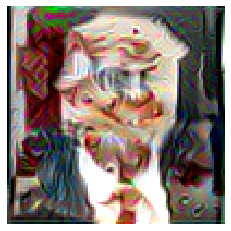

loss: 5417928192.0
info: {'grad': array([-1200.19189453, -3253.38574219, -1426.2409668 , ...,
       -1050.93103027, -1260.53076172, -1416.92944336]), 'task': b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT', 'funcalls': 107, 'nit': 100, 'warnflag': 1}


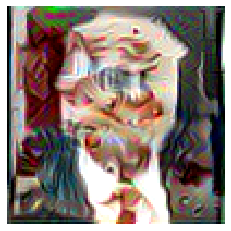

loss: 5521875968.0
info: {'grad': array([ -7699.88183594, -12972.70507812, -10749.74511719, ...,
          547.82080078,   3582.02856445,   1367.4934082 ]), 'task': b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT', 'funcalls': 104, 'nit': 100, 'warnflag': 1}


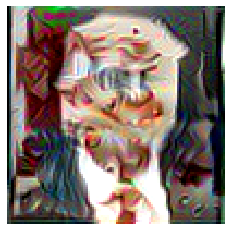

loss: 5493273600.0
info: {'grad': array([-12138.24707031, -30152.68554688, -22341.97265625, ...,
          888.60632324,   3939.13134766,    949.00219727]), 'task': b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT', 'funcalls': 105, 'nit': 100, 'warnflag': 1}


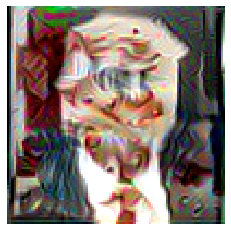

loss: 5467567104.0
info: {'grad': array([-2830.84790039, -9615.91503906, -7589.3046875 , ...,
        -167.28393555,  2581.23217773,  -615.97717285]), 'task': b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT', 'funcalls': 110, 'nit': 100, 'warnflag': 1}


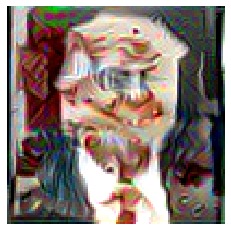

loss: 5453047808.0
info: {'grad': array([ -4001.70751953, -13803.67578125, -10346.91113281, ...,
           32.12713623,   1823.61523438,    -53.23701477]), 'task': b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT', 'funcalls': 106, 'nit': 100, 'warnflag': 1}


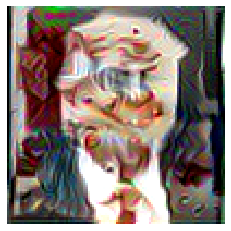

In [25]:
# crete an instance of the evaluator
evaluator = Evaluator(f_output)

# set the initial guess to the content image
initial_img = content_img

for i in range(iterations):
    # run the L-BFGS optimizer
    # this is the least memory intensive
    # the more iterations the better
    prediction, min_val, info = fmin_l_bfgs_b(evaluator.loss, 
                                     initial_img.flatten(), 
                                     fprime=evaluator.grads, 
                                     maxiter=loss_iterations)
    print('iteration: {}'.format(i))
    print('loss: {}'.format(min_val))
    print('info: {}'.format(info))

    # save img
    save_generated(channels, prediction, i, resize_dim)